# 第6章 所得分布はどのように生じるか(3)：シミュレーションモデル

第4章（乗算モデル → 対数正規分布）と第5章（交換モデル → 指数分布）で学んだ  
所得分布の生成メカニズムを、Rでシミュレーションして確かめます。

**この章の目標**:
- `sample()`, `replicate()` を使ったシミュレーションの基本を身につける
- 乗算過程が対数正規分布を生成することをシミュレーションで確認する
- 交換過程が指数分布を生成することをシミュレーションで確認する

*このノートブックは Claude Opus 4.6 を利用して作成しました。*

## 6.1 シミュレーションの準備

まず、シミュレーションに必要な基本操作を確認します。

### `set.seed()`: 乱数の再現性

シミュレーションでは乱数を使いますが、`set.seed()` で**乱数の種**を固定すると、毎回同じ結果が得られます。

In [1]:
set.seed(8931) # 好きな数字を入れてみよう
rnorm(5)

[1]  0.31332665  0.03081548
[3]  2.26467179 -0.74122658
[5] -0.79207000

In [2]:
# 同じシードを設定すると同じ結果が得られる
set.seed(8931)
rnorm(5)

[1]  0.31332665  0.03081548
[3]  2.26467179 -0.74122658
[5] -0.79207000

### `sample()`: 離散的なランダム抽出

In [3]:
# コイン投げを10回
set.seed(8931)
sample(c("表", "裏"), size = 10, replace = TRUE)

 [1] "裏" "表" "裏" "裏"
 [5] "表" "裏" "裏" "表"
 [9] "裏" "表"

In [4]:
# サイコロを1000回振って度数を数える
set.seed(8931)
dice <- sample(1:6, size = 1000, replace = TRUE)
table(dice)

dice
  1   2   3   4   5   6 
160 159 178 171 172 160 

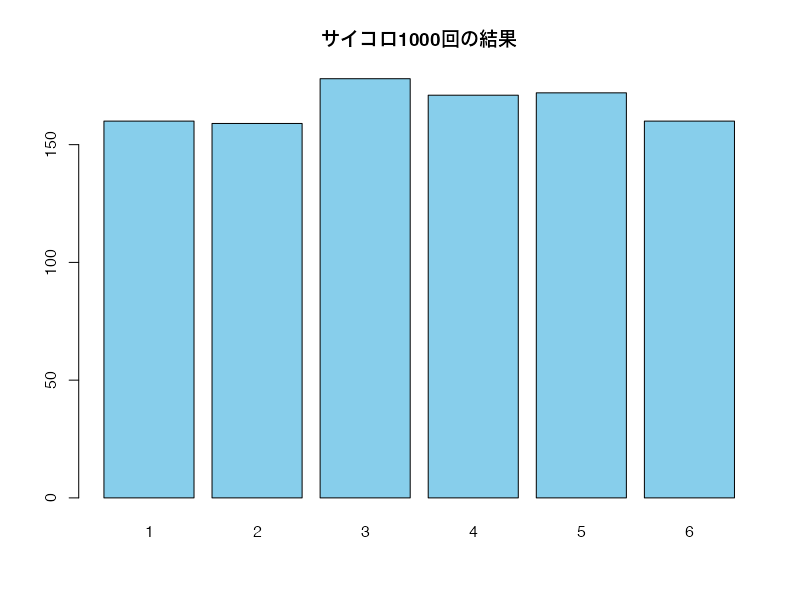

In [5]:
barplot(table(dice), col = "skyblue",
        main = "サイコロ1000回の結果")

### `replicate()`: 同じ操作の反復

シミュレーションの中核となる関数です。「同じ確率的な操作を何度も繰り返し、その結果の分布を調べる」ために使います。

In [6]:
# 「10個の正規乱数の平均」を1000回繰り返す
set.seed(8931)
sample_means <- replicate(1000, mean(rnorm(10)))

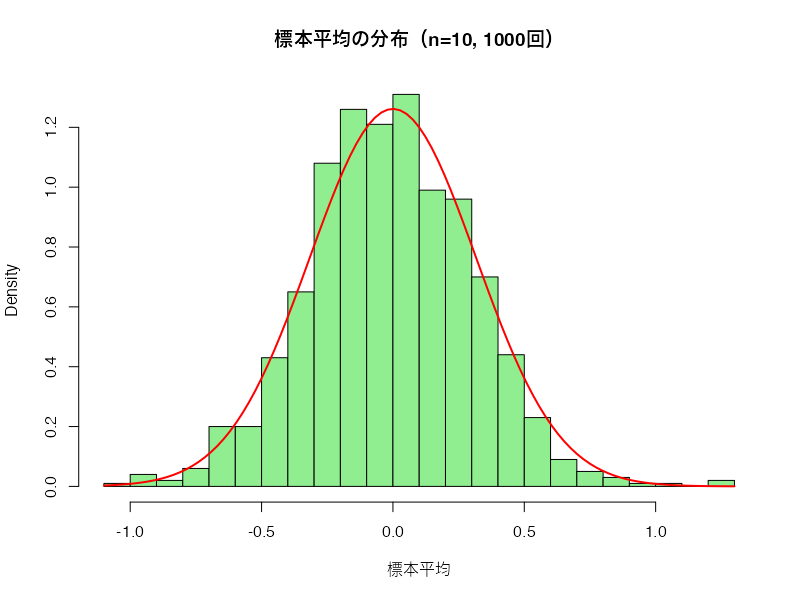

In [7]:
hist(sample_means, breaks = 30, prob = TRUE,
     col = "lightgreen",
     main = "標本平均の分布（n=10, 1000回）",
     xlab = "標本平均")
curve(dnorm(x, 0, 1/sqrt(10)), col = "red", lwd = 2, add = TRUE)

---

## 6.2 乗算モデルのシミュレーション

第4章で学んだ乗算モデルをシミュレーションします。

**モデルの設定**（講義ノート §4.6）:
- 確率 $p$ で手持ちを $b$ 倍できる試行を $n$ 回繰り返す
- 個人 $i$ の $n$ 回後の総所得: $Y_i = b^{W_i}$（$W_i$ は勝った回数）
- $W_i \sim \mathrm{Binomial}(n, p)$ なので、$Y_i$ は近似的に**対数正規分布**に従う

### 1人分の乗算ゲーム

In [8]:
# パラメータ設定
b <- 1.3    # 勝ったときの倍率
n <- 30     # 試行回数
p <- 0.7    # 勝つ確率

In [9]:
# 1人分のゲームをシミュレーション
set.seed(8931)
wins <- sample(c(0, 1), size = n, replace = TRUE, prob = c(1 - p, p))

In [10]:
# 勝った回数
W <- sum(wins)
W

[1] 22

In [11]:
# 総所得
Y <- b ^ W
Y

[1] 321.1839

### 多数の人に対するシミュレーション

In [12]:
# N人分の乗算ゲームをシミュレーション
N <- 10000   # 人数

set.seed(8931)
# 各人について n 回の sample 試行を行い、勝ち数を数える
W_all <- replicate(N, sum(sample(c(0, 1), size = n, replace = TRUE, prob = c(1 - p, p))))

In [13]:
# 各人の総所得
Y_all <- b ^ W_all

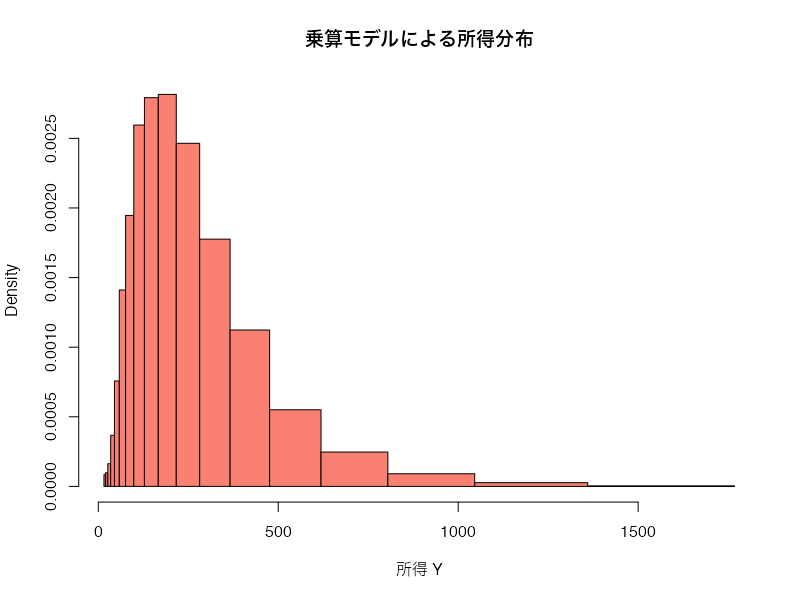

In [14]:
# 所得分布のヒストグラム
# Y = b^W で W は整数なので、隣接する値の中間点でビンを区切る
Y_vals <- sort(unique(Y_all))
breaks_Y <- c(Y_vals[1] / sqrt(b),
              Y_vals[-length(Y_vals)] * sqrt(b),
              Y_vals[length(Y_vals)] * sqrt(b))

hist(Y_all, breaks = breaks_Y, prob = TRUE,
     col = "salmon",
     main = "乗算モデルによる所得分布",
     xlab = "所得 Y")

右に裾の長い分布が見えます。次に対数をとってみましょう。

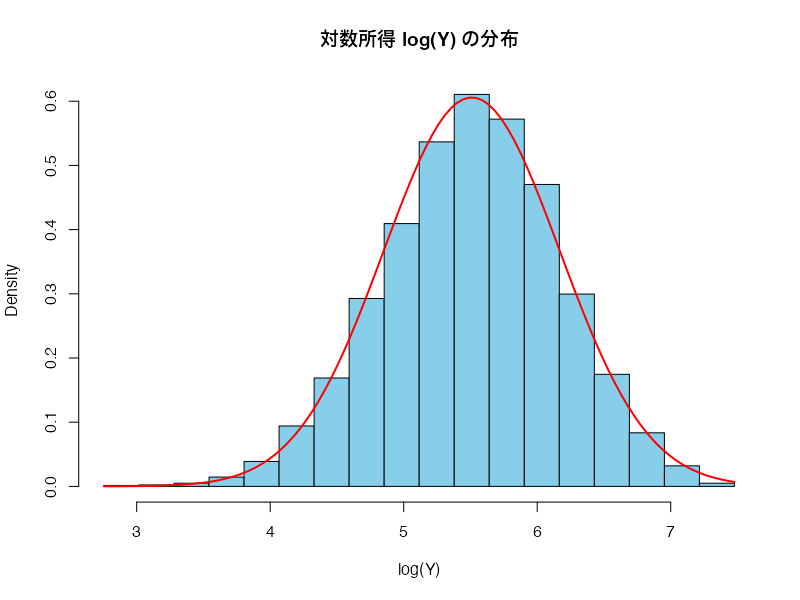

In [15]:
# 対数所得の分布
# log(Y) = W * log(b) は離散値なので、ビンの幅を log(b) に合わせる
log_b <- log(b)
breaks_seq <- seq(min(log(Y_all)) - log_b / 2, max(log(Y_all)) + log_b / 2, by = log_b)

hist(log(Y_all), breaks = breaks_seq, prob = TRUE,
     col = "skyblue",
     main = "対数所得 log(Y) の分布",
     xlab = "log(Y)")

# 理論的な正規分布を重ねる
mu    <- n * p * log_b
sigma <- sqrt(n * p * (1 - p)) * log_b
curve(dnorm(x, mu, sigma), col = "red", lwd = 2, add = TRUE)

> **確認**: $\log Y$ の分布は、理論値 $\mathrm{Normal}(np\log b,\; \sqrt{np(1-p)}\log b)$ の正規分布（赤い曲線）とよく一致しています。  
> これが「乗算過程 → 対数正規分布」の中心極限定理による説明です。

### 基本統計量の確認

In [16]:
mean(Y_all)

[1] 303.7231

In [17]:
median(Y_all)

[1] 247.0645

In [18]:
# 平均 > 中央値 → 右に裾の長い分布
mean(Y_all) > median(Y_all)

[1] TRUE

### パラメータを変えてみる

倍率 $b$ を変えると、所得分布の形状がどう変わるかを確認します。  
（講義ノート: $\partial G / \partial b > 0$、倍率が大きいほど不平等度が増す）

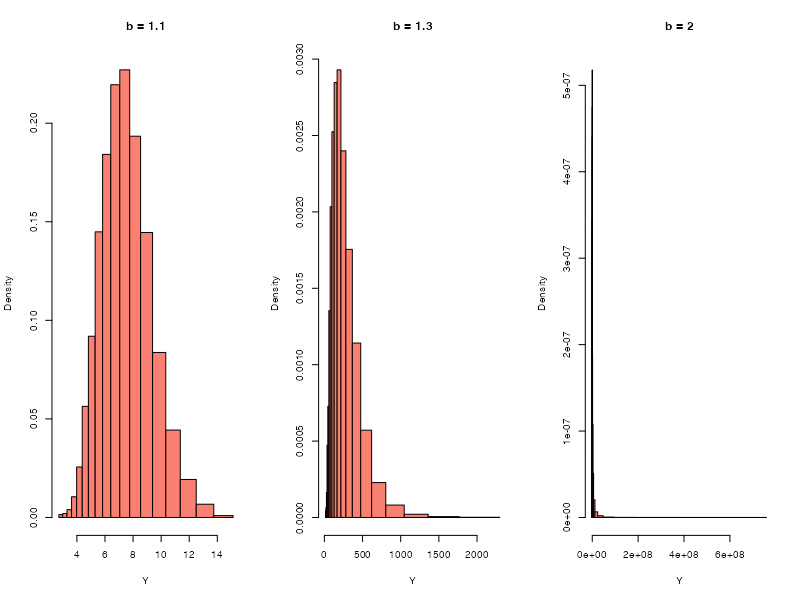

In [19]:
set.seed(8931)
par(mfrow = c(1, 3))

for (b_val in c(1.1, 1.3, 2.0)) {
  W_sim <- replicate(N, sum(sample(c(0, 1), size = n, replace = TRUE, prob = c(1 - p, p))))
  Y_sim <- b_val ^ W_sim
  Y_v <- sort(unique(Y_sim))
  br <- c(Y_v[1] / sqrt(b_val),
          Y_v[-length(Y_v)] * sqrt(b_val),
          Y_v[length(Y_v)] * sqrt(b_val))
  hist(Y_sim, breaks = br, prob = TRUE,
       col = "salmon", main = paste("b =", b_val),
       xlab = "Y")
}

par(mfrow = c(1, 1))

---

## 6.3 交換モデルのシミュレーション

第5章で学んだ Dragulescu & Yakovenko (2000) の交換モデルをシミュレーションします。

**モデルの設定**（講義ノート 第5章）:
- $N$ 人のエージェントが初期の所持金を持つ
- 毎ラウンド、ランダムにペアを組み、一方から他方へ金額 $\Delta m$ を移転する
- 貨幣の総量は保存される（ゼロサム）
- 負債は許容されない（$m_i \geq 0$）
- 十分な回数を繰り返すと、**指数分布** $P(m) \propto e^{-m/T}$（$T = M/N$）に収束する

In [20]:
# パラメータ設定（Dragulescu & Yakovenko, 2000, Fig.1 に対応）
N_agent  <- 500        # エージェント数
M_total  <- 500000     # 貨幣の総量
T_mean   <- M_total / N_agent  # 1人あたり平均（= 指数分布のパラメータ T）
n_rounds <- 400000     # 交換ラウンド数（元論文: time = 4 * 10^5）

In [21]:
# 初期状態：全員が同額を持つ
money <- rep(T_mean, N_agent)

In [22]:
# 交換シミュレーション
set.seed(8931)

for (t in 1:n_rounds) {
  # ランダムに2人を選び、一方を winner、他方を loser とする
  pair <- sample(N_agent, 2)
  loser  <- pair[1]
  winner <- pair[2]
  
  # 移転額: nu ~ Uniform(0,1) を毎回引き、delta_m = nu * M/N
  nu <- runif(1)
  delta_m <- nu * T_mean
  
  # loser の所持金が delta_m 以上のときのみ移転（非負制約）
  if (money[loser] >= delta_m) {
    money[loser]  <- money[loser]  - delta_m
    money[winner] <- money[winner] + delta_m
  }
}

In [23]:
# 保存則の確認：総額は変わっていないか？
sum(money)

[1] 5e+05

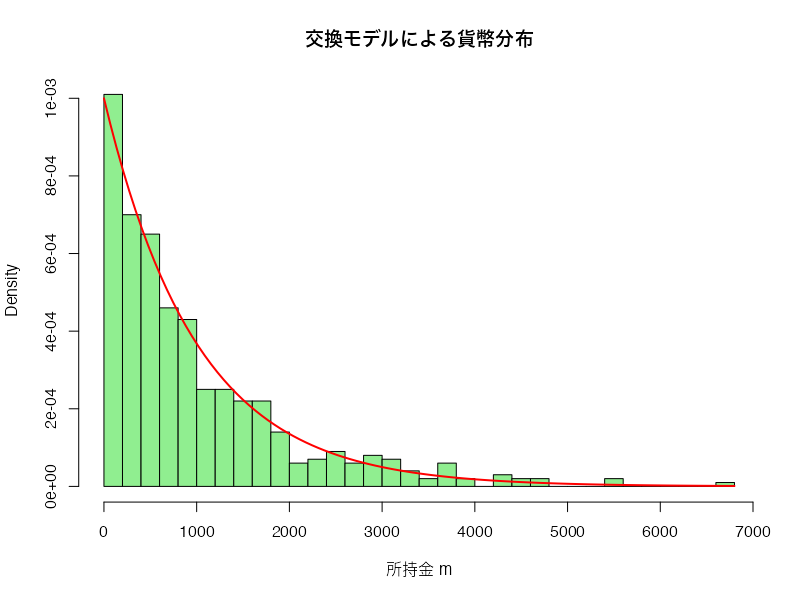

In [24]:
# 結果のヒストグラム
hist(money, breaks = 40, prob = TRUE,
     col = "lightgreen",
     main = "交換モデルによる貨幣分布",
     xlab = "所持金 m")

# 理論的な指数分布を重ねる
curve(dexp(x, rate = 1 / T_mean), col = "red", lwd = 2, add = TRUE)

> **確認**: シミュレーション結果（ヒストグラム）が理論的な指数分布（赤い曲線）とよく一致しています。  
> 全員が同額からスタートしても、ランダムな交換だけで不平等な分布が生じることがわかります。

### 対数スケールでの確認

指数分布であれば、対数スケールのプロットで直線になるはずです（Dragulescu & Yakovenko, 2000, Fig.1 の挿入図に対応）。

Warning message:
In xy.coords(x, y, xlabel, ylabel, log) :
  1 y value <= 0 omitted from logarithmic plot


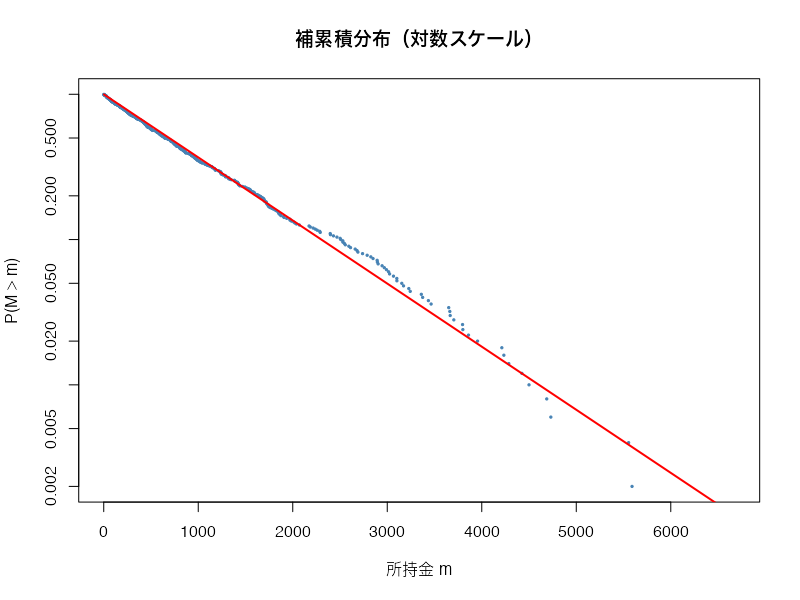

In [25]:
# 経験的な累積分布を対数スケールでプロット
money_sorted <- sort(money)
ecdf_vals <- 1 - (1:N_agent) / N_agent

plot(money_sorted, ecdf_vals, log = "y",
     pch = 20, cex = 0.5, col = "steelblue",
     main = "補累積分布（対数スケール）",
     xlab = "所持金 m",
     ylab = "P(M > m)")

# 理論値（指数分布の生存関数）
curve(exp(-x / T_mean), col = "red", lwd = 2, add = TRUE)

## まとめ

| | 乗算モデル | 交換モデル |
|---|---|---|
| メカニズム | 各期の所得 = 前期 × ランダムな倍率 | ランダムなペア間での貨幣移転 |
| 理論分布 | 対数正規分布 | 指数分布 |
| 分布の形状 | 右に裾が長い（中間層にピーク） | 右に裾が長い（低額にピーク） |
| 背景 | 資本の累積的成長（ピケティ $r > g$） | 統計力学のアナロジー（保存則） |

いずれのモデルも、単純なルールから「少数の高所得者と多数の低〜中所得者」という  
現実の所得分布の特徴を再現できることが確認できました。

### 補足：補累積分布による指数分布の確認

上の対数スケールのプロットでは、**補累積分布関数（CCDF）** $P(M > m)$ を用いて指数分布を確認している。

**手順**:
1. 所持金を小さい順に並べる：$m_{(1)} \leq m_{(2)} \leq \cdots \leq m_{(N)}$
2. $i$ 番目の値に対して $1 - i/N$ を割り当てる（= 所持金が $m_{(i)}$ より大きい人の割合）
3. $y$ 軸を対数スケールでプロットする

**なぜ直線になるか**:
指数分布の密度関数 $f(m) = \frac{1}{T}e^{-m/T}$（$m \geq 0$）を $m$ から $\infty$ まで積分すると、

$$P(M > m) = \int_m^{\infty} \frac{1}{T}e^{-s/T} \, ds = \left[-e^{-s/T}\right]_m^{\infty} = e^{-m/T}$$

両辺の対数をとると、

$$\log P(M > m) = -\frac{m}{T}$$

すなわち $m$ に対して傾き $-1/T$ の**直線**になる。ヒストグラムではビンの取り方に結果が左右されるが、補累積分布はビンに依存しないため、分布の形状をより直接的に確認できる。